In [1]:
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.simple_classifier import SimpleCNN

In [ ]:
# global params
LEARNING_RATE   = 1.e-3
NUM_EPOCHS      = 10

In [2]:
# Load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def train_model(batch_size: int) -> Tuple[nn.Module, list, list]:
    print(f"TRAINING WITH BATCH_SIZE {batch_size}")
    train_loader = torch.utils.data.DataLoader(train_set, 
                                               batch_size=batch_size,
                                               shuffle=True)
    
    model = SimpleCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    epochs = NUM_EPOCHS

    train_loss, train_acc = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        
        for images, labels in tqdm(train_loader, desc=f"epoch {epoch+1}/{epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / len(train_set))

        # print(f"epoch {epoch+1}/{epochs}, ",
        #       f"loss: {running_loss/len(train_loader):.4f} ",
        #       f"accuracy: {100 * correct / len(train_set):.2f}%")

    return model, train_loss, train_acc


@torch.no_grad()  # wrapper to reduce tabs, use it instead of `with torch.no_grad`
def test_model(model: nn.Module, batch_size: int) -> list:
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    model.eval()
    correct = 0

    for images, labels in tqdm(test_loader, desc="Testing", leave=False):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # pred, indice
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / len(test_set)
    print(f'test accuracy for model with batch size {batch_size}: {accuracy:.2f}%')
    return accuracy

In [6]:
# test setup
BATCH_SIZES = [2, 4, 8, 16, 32]
models = {}
metrics = {}

for batch_size in BATCH_SIZES:
    model, loss, acc = train_model(batch_size=batch_size)
    models[batch_size] = model
    metrics[batch_size] = {"loss": loss, "acc": acc}

for batch_size in BATCH_SIZES:
    test_acc = test_model(models[batch_size], batch_size=batch_size)

TRAINING WITH BATCH_SIZE 2


TRAINING WITH BATCH_SIZE 4


TRAINING WITH BATCH_SIZE 8


TRAINING WITH BATCH_SIZE 16


TRAINING WITH BATCH_SIZE 32


test accuracy for model with batch size 2: 65.01%


test accuracy for model with batch size 4: 66.13%


test accuracy for model with batch size 8: 67.71%


test accuracy for model with batch size 16: 68.26%


test accuracy for model with batch size 32: 69.38%


In [10]:
def plot_stuff(metrics_dict: dict, batch_sizes: list, metric: str = "acc") -> None:
    plt.figure(figsize=(8, 4))
    for batch_size in batch_sizes:
        plt.plot(metrics_dict[batch_size][metric], label=f"batch size = {batch_size}")
    plt.title(f"Comparison of {metric} for multiple batch sizes")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

    for batch_size in batch_sizes:
        print(f"{metric} with batch size = {batch_size}: {metrics_dict[batch_size][metric][-1]}")

#### Setup:
- lr: 1e-3,
- epochs: 10,
- model: 2 layers of conv2d, relu, maxpool + 2 layers of fc
- batch sizes: 2 and 16 -> comparison for if batch_size < num_classes and batch_size > num_classes

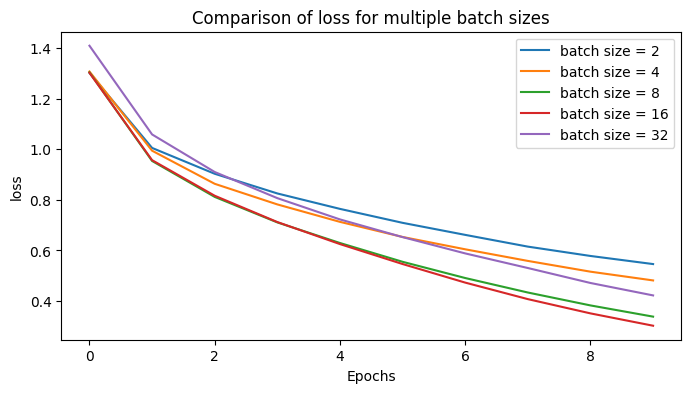

loss with batch size = 2: 0.5460908553635276
loss with batch size = 4: 0.48147758997174767
loss with batch size = 8: 0.3384568397662789
loss with batch size = 16: 0.3025700568029284
loss with batch size = 32: 0.42228850902499715


In [11]:
plot_stuff(metrics, BATCH_SIZES, "loss")

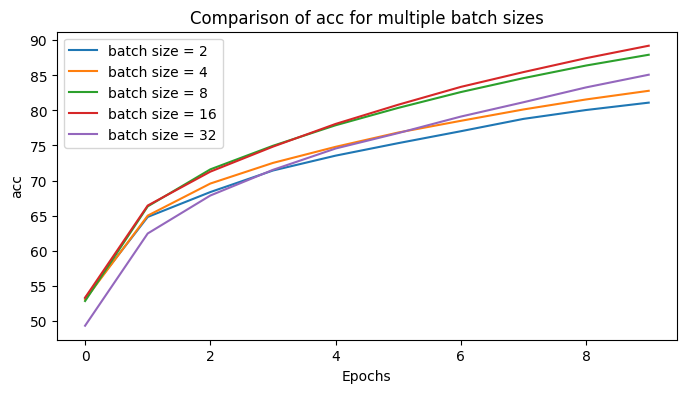

acc with batch size = 2: 81.112
acc with batch size = 4: 82.802
acc with batch size = 8: 87.944
acc with batch size = 16: 89.234
acc with batch size = 32: 85.096


In [12]:
plot_stuff(metrics, BATCH_SIZES, "acc")

In [14]:
# saved models so no need to wait 40+ minutes for lower batch size trains again.
for bs, model in models.items():
    torch.save(model.state_dict(), f"models/batch_size_compare_{bs}.pth")